1. Offline augmentation (przed treningiem)
   - zbalansowanie klas
   - augmentacja waveformów
   - augmentacja spektrogramów
   - wygenerowanie przykładów dla klasy silence
   - wygenerowanie spektrogramów

In [1]:
import torchaudio
import torchaudio.transforms as T
from WaveformAugmentations import WaveformAugmentations
from SpectrogramAugmentations import SpectrogramAugmentations
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
wav_path = r".\data\train\audio\house\0ab3b47d_nohash_0.wav"
waveform, sample_rate = torchaudio.load(wav_path)
waveform = waveform.squeeze(0)  # remove channel dimension
Audio(waveform.numpy(), rate=sample_rate)

In [3]:
# test time shift augmentation
augmented_waveform = WaveformAugmentations.time_shift(waveform, shift_limit=0.4)
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [4]:
# test noise addition
augmented_waveform = WaveformAugmentations.add_noise(waveform, noise_level=0.005)
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [5]:
# test pitch shift augmentation
augmented_waveform = WaveformAugmentations.pitch_shift(waveform, sample_rate)
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [6]:
# test volume control
augmented_waveform = WaveformAugmentations.volume_control(waveform, gain_range=(6, 10))
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [7]:
# test speed_change
augmented_waveform = WaveformAugmentations.speed_change(waveform, sample_rate, speed_range=(0.8, 1.2))
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [8]:
# test reverb
augmented_waveform = WaveformAugmentations.reverb(waveform, sample_rate, reverb_range=(0.5, 0.7))
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [9]:
# test background mix
background_path = r".\data\train\audio\_background_noise_\exercise_bike.wav"
background_waveform, _ = torchaudio.load(background_path)
background_waveform = background_waveform.squeeze(0)  # remove channel dimension

augmented_waveform = WaveformAugmentations.mix_background(waveform, background_waveform, mix_ratio_range=(0.1, 0.3))
Audio(augmented_waveform.numpy(), rate=sample_rate)

In [10]:
# test convolution reverb
rir_path = r".\data\train\audio\_background_noise_\running_tap.wav"
rir_waveform, _ = torchaudio.load(rir_path)
rir_waveform = rir_waveform.squeeze(0)  # remove channel dimension
augmented_waveform = WaveformAugmentations.convolution_reverb(waveform, rir_waveform)
Audio(augmented_waveform.numpy(), rate=sample_rate)

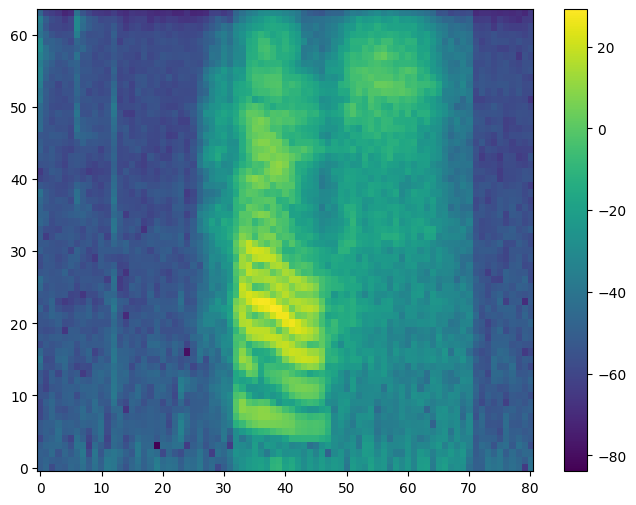

In [11]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_mels=64,
)
db_transform = T.AmplitudeToDB()

spectrogram = mel_spectrogram(waveform)
spectrogram = db_transform(spectrogram)

plt.figure(figsize=(8, 6))
plt.imshow(spectrogram.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

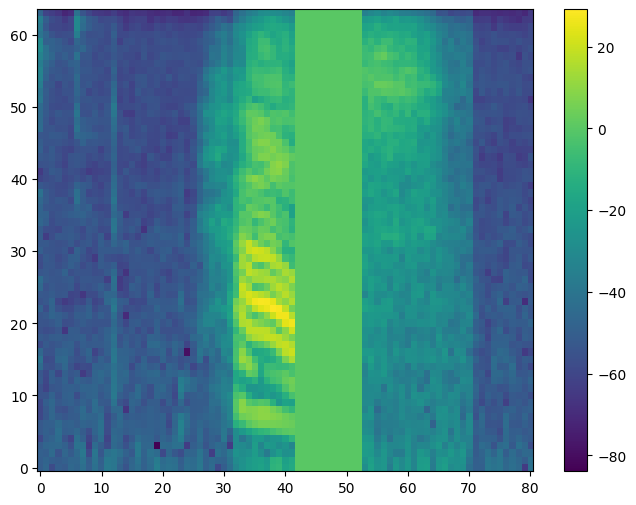

In [12]:
# test time_masking augmentation
augmented_spectrogram = SpectrogramAugmentations.time_masking(spectrogram, time_mask_param=20)
plt.figure(figsize=(8, 6))
plt.imshow(augmented_spectrogram.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

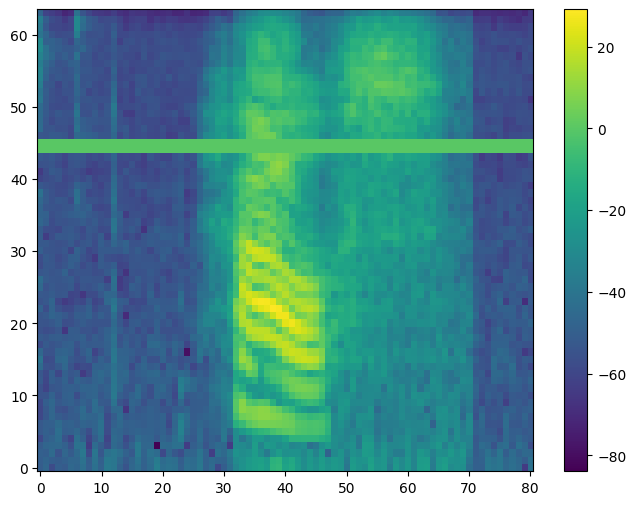

In [13]:
# test freq_masking augmentation
augmented_spectrogram = SpectrogramAugmentations.freq_masking(spectrogram, freq_mask_param=20)
plt.figure(figsize=(8, 6))
plt.imshow(augmented_spectrogram.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

In [ ]:
import os
import torch
import torchaudio.transforms as T
import soundfile as sf
from tqdm import tqdm

def preprocess_and_save_spectrograms(
    audio_dir, 
    output_dir, 
    sample_rate=16000,
    n_mels=64, 
    n_fft=400, 
    hop_length=200,
    waveform_transform=None,
    spectrogram_transform=None,
):
    os.makedirs(output_dir, exist_ok=True)
    
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )
    db_transform = T.AmplitudeToDB()
    
    print(f"Loading audio files from {audio_dir}...")
    audio_files = []
    for root, _, files in os.walk(audio_dir):
        for file in files:
            if file.endswith('.wav'):
                audio_files.append(os.path.relpath(os.path.join(root, file), audio_dir))

    print(f"Processing {len(audio_files)} audio files...")
    for audio_file in tqdm(audio_files, desc="Processing audio files"):
        # Load audio
        audio_path = os.path.join(audio_dir, audio_file)
        data, orig_sr = sf.read(audio_path)
        waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        if waveform_transform:
            waveform = waveform_transform(waveform)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resample if necessary
        if orig_sr != sample_rate:
            resampler = T.Resample(orig_freq=orig_sr, new_freq=sample_rate)
            waveform = resampler(waveform)
        
        spec = mel_spectrogram(waveform)
        spec = db_transform(spec)

        if spectrogram_transform:
            spec = spectrogram_transform(spec)

        output_path = os.path.join(output_dir, os.path.splitext(audio_file)[0] + '.pt')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        torch.save(spec, output_path)
    print(f"Spectrograms saved to {output_dir}")

preprocess_and_save_spectrograms("data/train/audio", "data/train/spectrograms")


In [ ]:
def generate_silence_class():
    pass

def balance_dataset():
    pass


In [ ]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import soundfile as sf
import torchaudio.transforms as T


# Global transforms for spectrogram generation
mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=64)
db_transform = T.AmplitudeToDB()

class AudioSpectrogramsDataset(Dataset):
    pass